# Package Installations 

In [2]:
install_packages = False 
if install_packages:
  !pip3 install torch torchvision  

In [82]:
import os 
import json
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import importlib
import torch
import PIL
from torchvision.transforms import v2


from tensorflow import keras

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model


from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import MobileNet, MobileNetV3Large, MobileNetV3Small, MobileNetV2


from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPool2D, MaxPool1D, BatchNormalization
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense


from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

from utils import *
from img_utils import *
from img_utils import plot_hist

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading Data 

In [58]:
path = "../nybolig-scrape/output"
houses_df = data_to_DF(path, max_houses=1000)

[ WARN:0@17082.947] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@17090.106] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity


In [59]:
from utils import print_DF_price_stats
from utils import remove_outliers

#Take only Copenhagen, and Ejerlejligheder
houses_df = houses_df[(houses_df['postal_code'] >= 1000) & (houses_df['postal_code'] <= 2920)]
houses_df = houses_df[houses_df['type'] == 'ejerlejlighed']

#Get some stat
print_DF_price_stats(houses_df)

#Remove theoutliers 
houses_df = remove_outliers(houses_df, 'price')
print_DF_price_stats(houses_df)

Number of datapoints: 280
Mean price: 4595017.857142857
Median price: 3795000.0
Min price: 1150000
Max price: 30000000
Standard deviation of price:3055198.3896953114
Number of datapoints: 272
Mean price: 4259650.735294118
Median price: 3695000.0
Min price: 1150000
Max price: 10500000
Standard deviation of price:2170909.8164294087


# Setting up splits 

In [60]:
from sklearn.model_selection import train_test_split
from img_utils import prices_to_n_labels


# Split the data into train, validation and test sets with a 60-20-20 ratio
train_df, test_df = train_test_split(houses_df, test_size=0.2, random_state=0)
train_df, valid_df = train_test_split(train_df, test_size=0.20, random_state=0)

# Loading Images

In [80]:
# As most of the original images are 2100x1400, we resize them to 224x224, as this is what the model operates on
target_width = 224
target_height = 224

resize = True
gray_scale = False
threshhold = True
scale = False

train_images = preprocess_images(train_df, "image_floorplan", target_width, target_height, resize, gray_scale, threshhold)
validation_images = preprocess_images(valid_df, "image_floorplan", target_width, target_height, resize, gray_scale, threshhold)
test_images = preprocess_images(test_df, "image_floorplan", target_width, target_height, resize, gray_scale, threshhold)

#Rescale the images with keras 
if scale:
  from keras.applications.mobilenet_v2 import preprocess_input
  train_images = preprocess_input(train_images)
  validation_images = preprocess_input(validation_images)
  test_images = preprocess_input(test_images)


# MobileNet: Transfer Learning with Pre-trained Wieghts 

In [114]:
def build_and_fit_model(pretrained_model, 
                        train_images, train_labels,
                        validation_images, valid_labels,
                        num_classes, 
                        input_shape, model_output:str): 
  """
  Function to build and fit a model with a pretrained model and a new classification layer
  """

  #Load the Pretrained Model
  base_model = pretrained_model(weights="imagenet", include_top=False, input_shape = input_shape) 

  # Freeze the pretrained weights
  for layer in base_model.layers:
    layer.trainable = False

  # Create the model with the pretrained model and a new classification layer
  model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    #layers.Dropout(0.2),
    Dense(256, activation='relu'),
    #layers.Dropout(0.1), 
    #Dense(128, activation='leaky_relu'),
    Dense(1, activation='linear') if model_output == 'continuous' else Dense(num_classes, activation='softmax')
  ])

  #Check which type of model we are building
  if model_output == 'continuous':
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='mean_absolute_error', 
                  metrics=['mean_absolute_error', 'mean_squared_error'])
  
  if (model_output == 'classification'):
    model.compile(optimizer=Adam(learning_rate=0.001),  
                  loss='categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy' , 
                  metrics=['accuracy'])
  
  #Fit the model 
  fit_history = model.fit(
  train_images, 
  train_labels,
  #steps_per_epoch=8, 
  epochs=100, 
  #verbose = 1,
  #batch_size=32
  validation_data=(validation_images, valid_labels), 
  callbacks=[EarlyStopping(patience=3)],
  )
  return model, fit_history

# Binary Model 

In [96]:
from img_utils import prices_to_n_labels, label_to_price
num_labels = 3
train_labels = prices_to_n_labels(houses_df['price'], train_df['price'], num_labels)
valid_labels = prices_to_n_labels(houses_df['price'], valid_df['price'], num_labels)
test_labels = prices_to_n_labels(houses_df['price'], test_df['price'], num_labels)

[0. 1. 0.]
low 2895000.0 high 4697000.0
4697000.0


In [70]:
pretrained_model = MobileNet  
binary_model, binary_fit_history = build_and_fit_model(pretrained_model, 
                                                       train_images, train_labels, 
                                                       validation_images, valid_labels, 
                                                       num_labels, 
                                                       input_shape = (target_width, target_height, 3),
                                                       model_output = 'classification')

Epoch 1/20
6/6 [==============================] - 13s 1s/step - loss: 14.8390 - accuracy: 0.5780 - val_loss: 8.8248 - val_accuracy: 0.5682
Epoch 2/20
6/6 [==============================] - 7s 1s/step - loss: 3.3928 - accuracy: 0.6416 - val_loss: 3.9592 - val_accuracy: 0.6818
Epoch 3/20
6/6 [==============================] - 7s 1s/step - loss: 1.4928 - accuracy: 0.8497 - val_loss: 2.6061 - val_accuracy: 0.7045
Epoch 4/20
6/6 [==============================] - 7s 1s/step - loss: 0.6456 - accuracy: 0.8613 - val_loss: 3.3478 - val_accuracy: 0.7045
Epoch 5/20
6/6 [==============================] - 7s 1s/step - loss: 0.7004 - accuracy: 0.8786 - val_loss: 3.8186 - val_accuracy: 0.5682
Epoch 6/20
6/6 [==============================] - 7s 1s/step - loss: 0.0859 - accuracy: 0.9769 - val_loss: 2.5745 - val_accuracy: 0.7273
Epoch 7/20
6/6 [==============================] - 7s 1s/step - loss: 0.0890 - accuracy: 0.9884 - val_loss: 3.1007 - val_accuracy: 0.5227
Epoch 8/20
6/6 [=======================

Plot the training history


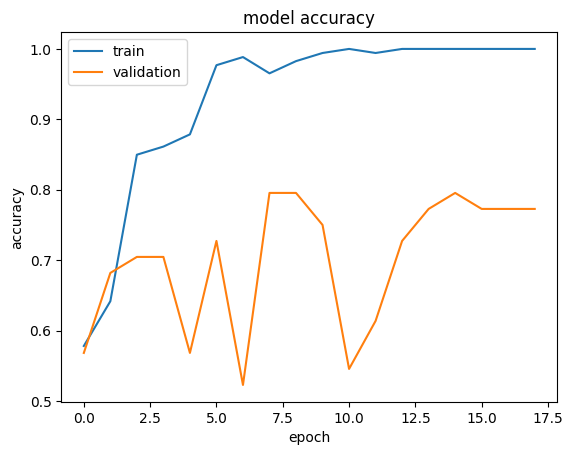

Evaluate the model:
2/2 [==============================] - 4s 651ms/step
Accuracy: 0.78
Precision: 0.80
Recall: 0.78


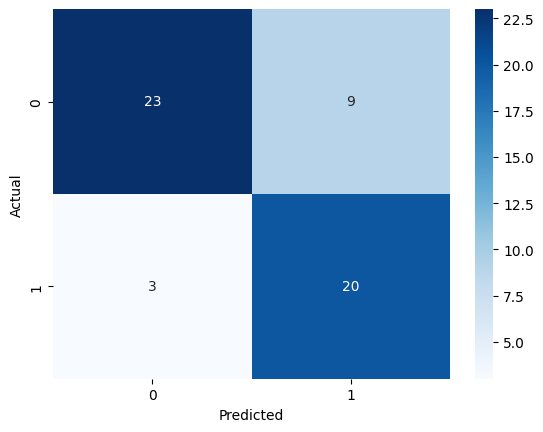

In [71]:
#Plot the training history
print("Plot the training history")
plot_hist(binary_fit_history)

# Evaluate the model
print("Evaluate the model:")
binary_model.evaluate(test_images, test_labels)

from img_utils import label_score
binary_model_predictions = binary_model.predict(test_images)
binary_model_predictions = np.argmax(binary_model_predictions, axis=1)
binary_model_actual = np.argmax(test_labels, axis=1)
label_score(binary_model_predictions, binary_model_actual)

# 3-Label Model 

In [53]:
num_labels = 3
train_labels = prices_to_n_labels(houses_df['price'], train_df['price'], num_labels)
valid_labels = prices_to_n_labels(houses_df['price'], valid_df['price'], num_labels)
test_labels = prices_to_n_labels(houses_df['price'], test_df['price'], num_labels)

label_model, label_fit_history = build_and_fit_model(pretrained_model,
                                                      train_images, train_labels, 
                                                      validation_images, valid_labels, 
                                                      num_labels, 
                                                      input_shape = (target_width, target_height, 3),
                                                      model_output='classification')

Epoch 1/10
8/8 [==============================] - 14s 1s/step - loss: 15.8562 - accuracy: 0.4525 - val_loss: 4.3753 - val_accuracy: 0.3778
Epoch 2/10
8/8 [==============================] - 8s 979ms/step - loss: 4.1704 - accuracy: 0.5642 - val_loss: 4.6541 - val_accuracy: 0.5111
Epoch 3/10
8/8 [==============================] - 8s 1s/step - loss: 1.8592 - accuracy: 0.7709 - val_loss: 3.1684 - val_accuracy: 0.5111
Epoch 4/10
8/8 [==============================] - 8s 990ms/step - loss: 1.1348 - accuracy: 0.8659 - val_loss: 6.3604 - val_accuracy: 0.4222
Epoch 5/10
8/8 [==============================] - 8s 975ms/step - loss: 0.4550 - accuracy: 0.9050 - val_loss: 5.3768 - val_accuracy: 0.6000
Epoch 6/10
8/8 [==============================] - 8s 966ms/step - loss: 0.2511 - accuracy: 0.9497 - val_loss: 6.0590 - val_accuracy: 0.4000


Plot the training history


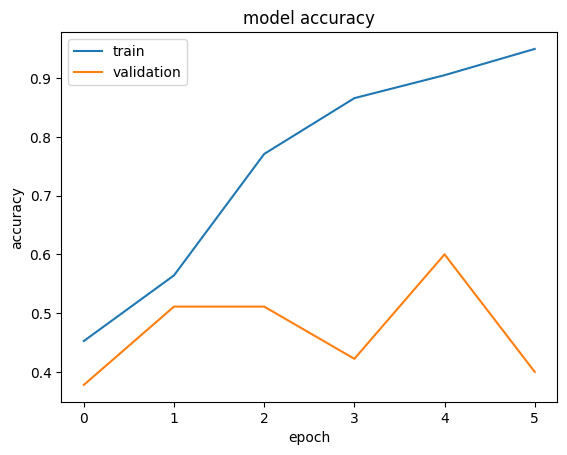

Evaluate the model:
2/2 [==============================] - 2s 563ms/step
Accuracy: 0.41
Precision: 0.60
Recall: 0.41


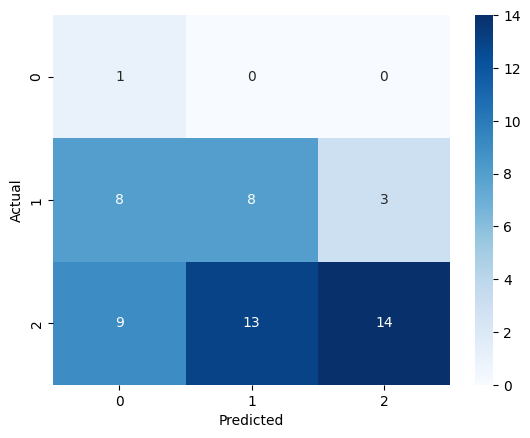

In [54]:
#Plot the training history
print("Plot the training history")
plot_hist(label_fit_history)

# Evaluate the model
print("Evaluate the model:")
label_model.evaluate(test_images, test_labels)

from img_utils import label_score
label_model_predictions = label_model.predict(test_images)
label_model_predictions = np.argmax(label_model_predictions, axis=1)
label_model_actual = np.argmax(test_labels, axis=1)
label_score(label_model_predictions, label_model_actual)

# Continous Predictions

In [115]:
from keras.preprocessing.image import ImageDataGenerator
train_labels = train_df['price']
valid_labels = valid_df['price']
test_labels = test_df['price']

pretrained_model = MobileNetV3Large
input_shape = train_images[0].shape

regression_model, regression_fit_history = build_and_fit_model(pretrained_model,
                                                                train_images, train_labels, 
                                                                validation_images, valid_labels, 
                                                                num_classes= None, 
                                                                input_shape = (target_width, target_height, 3),
                                                                model_output='continuous')                                                     

Epoch 1/100
6/6 [==============================] - 20s 2s/step - loss: 4181218.5000 - mean_absolute_error: 4181218.5000 - val_loss: 4672668.5000 - val_mean_absolute_error: 4672668.5000
Epoch 2/100
6/6 [==============================] - 7s 1s/step - loss: 4179024.0000 - mean_absolute_error: 4179024.0000 - val_loss: 4668947.5000 - val_mean_absolute_error: 4668947.5000
Epoch 3/100
6/6 [==============================] - 8s 1s/step - loss: 4174013.7500 - mean_absolute_error: 4174013.7500 - val_loss: 4661668.0000 - val_mean_absolute_error: 4661668.0000
Epoch 4/100
6/6 [==============================] - 8s 1s/step - loss: 4164811.5000 - mean_absolute_error: 4164811.5000 - val_loss: 4649205.0000 - val_mean_absolute_error: 4649205.0000
Epoch 5/100
6/6 [==============================] - 9s 2s/step - loss: 4149526.2500 - mean_absolute_error: 4149526.2500 - val_loss: 4629502.5000 - val_mean_absolute_error: 4629502.5000
Epoch 6/100
6/6 [==============================] - ETA: 0s - loss: 4126122.5000

In [101]:
save = True
if save: 
  regression_model.save('MobileNet_Continous.keras')

Evaluate the model:
2/2 [==============================] - 2s 769ms/step
R2 score: 0.23
Mean Absolute Error: 1250607.35
Mean Squared Error: 2958312805042.35


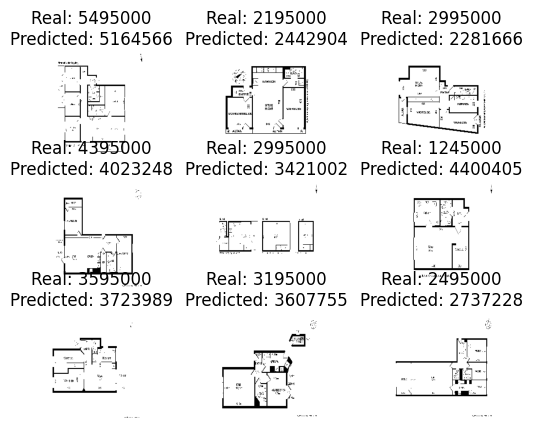

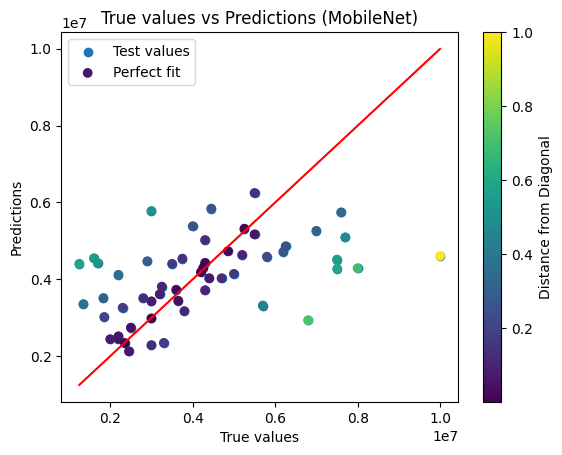

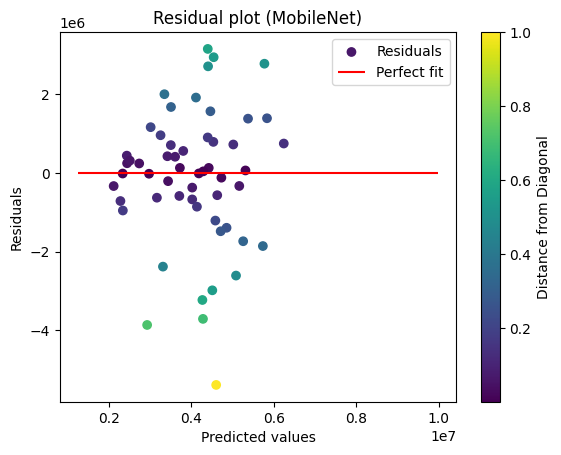

In [104]:
#Evaluate the model
from img_utils import print_scores_prices, plot_predictions
from utils import plot_regression_results
print("Evaluate the model:")
regression_model.evaluate(test_images, test_labels)
predicted_prices = regression_model.predict(test_images)
predicted_prices = predicted_prices
actual_prices = test_df['price'].values

print_scores_prices(actual_prices, predicted_prices)
plot_predictions(test_images, actual_prices, predicted_prices)
plot_regression_results("MobileNet", actual_prices , predicted_prices.flatten())